# TrkQualTrain.ipynb

The notebook to train the TrkQual algorithm. Note that this runs on v6 EventNtuples. The general workflow is:
* take EventNtuple datasets and produce smaller trkqual_tree files,
* take data from the trkqual_tree files and train the TrkQual ANN, and
* save the model, plots, etc.

In [1]:
class Dataset:
    """Define datasets for TrkQual training"""

    def __init__(self, id, dataset, trkqual_tree_dirname, is_training):
        self.id = id
        self.dataset = dataset
        self.filelist = "filelists/"+dataset+".list"
        self.trkqualtree = trkqual_tree_dirname + "/trkqual_tree_v2.0_"+id+".root"
        self.is_training = is_training

    def add(self, features, reco_mom, mc_mom):
        self.features = features
        self.reco_mom = reco_mom
        self.mc_mom = mc_mom
        
        self.mom_res = self.reco_mom - self.mc_mom
        self.high_qual = (self.mom_res>-0.25) & (self.mom_res<0.25)
        self.low_qual = (self.mom_res>0.7)

    def add_predictions(self, predictions):
        self.predictions = predictions

## Setting Up

Here we:
* define which datasets we will train and validate one, and
* define where we want the trkqual trees to go

In [2]:
# The EventNtuple datasets we need
trkqual_tree_dirname = '/exp/mu2e/data/users/edmonds/TrkQualTraining'
treename = "trkqualtree"

is_training = True
is_not_training = False
training_dataset = Dataset("training", "nts.mu2e.FlateMinusMix1BBTriggered.MDC2020aw_best_v1_3_v06_06_00.root", trkqual_tree_dirname, is_training)
validation_dataset = Dataset("validation", "nts.mu2e.CeEndpointMix1BBTriggered.MDC2020aw_best_v1_3_v06_06_00.root", trkqual_tree_dirname, is_not_training)
ensemble_dataset = Dataset("ensemble", "nts.mu2e.ensembleMDS2cMix1BBTriggered.MDC2020ba_best_v1_3_v06_06_00.root", trkqual_tree_dirname, is_not_training)

# The model
modelname = 'TrkQual_ANN1_v2.0'

datasets = [ training_dataset, validation_dataset, ensemble_dataset ]

## Create TrkQual trees

In [3]:
for dataset in datasets:
    bash_script=f"""
    source /cvmfs/mu2e.opensciencegrid.org/setupmu2e-art.sh
    muse setup EventNtuple
    if [ -f {dataset.trkqualtree} ]; then 
        echo Training tree {dataset.trkqualtree} already exists
    else 
       echo Training tree {dataset.trkqualtree} does not exist. Making now...
    
        if [ -f {dataset.filelist} ]; then
           echo Filelist already exists
        else
            echo " Creating filelist..."
            setup mu2efiletools
            mu2eDatasetFileList {dataset.dataset} > {dataset.filelist}
        fi
        
        root -l -b -q scripts/TrkQualTree.C++\\(\\"{dataset.filelist}\\",\\"{dataset.trkqualtree}\\"\\)
    fi
    """
    # Execute the bash script
    get_ipython().run_cell_magic('bash', '', bash_script)

print("Done!")

     Build: prof     Core: al9 e29 p084     Options: 
Training tree /exp/mu2e/data/users/edmonds/TrkQualTraining/trkqual_tree_v2.0_training.root already exists
     Build: prof     Core: al9 e29 p084     Options: 
Training tree /exp/mu2e/data/users/edmonds/TrkQualTraining/trkqual_tree_v2.0_validation.root already exists
     Build: prof     Core: al9 e29 p084     Options: 
Training tree /exp/mu2e/data/users/edmonds/TrkQualTraining/trkqual_tree_v2.0_ensemble.root already exists
Done!


In [4]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
#import xgboost # not in pyana
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc

import tf2onnx
import onnx

2025-09-22 10:15:15.407811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read TrkQual Tree for training

First, we declare a useful functions that will make aliases and calculate some new columns

In [5]:
def add_useful_columns(batch):
    # Calculate magnitude of the momenta
    batch['trk_ent.mom'] = (batch['trk_ent.mom.fCoordinates.fX']**2 + batch['trk_ent.mom.fCoordinates.fY']**2 + batch['trk_ent.mom.fCoordinates.fZ']**2)**0.5
    batch['trk_ent_mc.mom'] = (batch['trk_ent_mc.mom.fCoordinates.fX']**2 + batch['trk_ent_mc.mom.fCoordinates.fY']**2 + batch['trk_ent_mc.mom.fCoordinates.fZ']**2)**0.5
    
    # For masks
    #batch['ent_fit_is_highmom'] = ak.flatten(ak.any( (batch['demfit.mom']>80) & (batch['demfit.sid']==0), axis=-1, keepdims=True))
    
    # For training features
    batch['trk.factive'] = batch['trk.nactive'] / batch['trk.nhits']
    batch['trk.fambig'] = batch['trk.nnullambig'] / batch['trk.nactive']
    batch['trk.fstraws'] = batch['trk.nmatactive'] / batch['trk.nactive']


Now we extract our features and targets from the TrkQual trees for both training and validation datasets

In [6]:
input_var_names = ["nactive", "factive", "t0err", "fambig", "fitcon", "momerr", "fstraws"]
n_input_vars = len(input_var_names)

for dataset in datasets:

    # We will put the variables we want into numpy arrays
    trk_ent_mom=[] # reco momentum at tracker entrance
    trk_ent_mc_mom=[] # MC true momentum at tracker entrance

    # The variables we need for the features we will train on
    nactive=[]
    factive=[]
    t0err=[]
    momerr=[]
    fambig=[]
    fitcon=[]
    fstraws=[]

    trkqual_tree = uproot.open(dataset.trkqualtree+":"+treename)
    print(dataset.trkqualtree.split('/')[-1].strip('\n') + ": "+str(trkqual_tree.num_entries)+" entries")
    # Iterate through the entries in the file
    for batch, report in trkqual_tree.iterate(step_size="10 MB", report=True, library='ak'):
        # Make some aliases for new columns
        add_useful_columns(batch)
    
        # A mask for selecting good tracks to tracks to train on
        # startCode 173 is for FlateMinus
        track_mask = (batch['trk.status']>0) & (batch['trk.goodfit']==1) & ~np.isnan(batch['trk_ent_pars.t0err'])
        if dataset.is_training:
            track_mask = (track_mask) & (batch['trk_sim.startCode']==173)
    
        # Here we keep on appending to the arrays
        trk_ent_mom = np.append(trk_ent_mom, (batch['trk_ent.mom'][track_mask]).to_numpy())
        trk_ent_mc_mom = np.append(trk_ent_mc_mom, (batch['trk_ent_mc.mom'][track_mask]).to_numpy())

        # The features we will train ong
        nactive = np.append(nactive, (batch['trk.nactive'][track_mask]).to_numpy())
        factive = np.append(factive, (batch['trk.factive'][track_mask]).to_numpy())
        fambig = np.append(fambig, (batch['trk.fambig'][track_mask]).to_numpy())
        fstraws = np.append(fstraws, (batch['trk.fstraws'][track_mask]).to_numpy())           
        t0err = np.append(t0err, batch['trk_ent_pars.t0err'][track_mask].to_numpy())   
        fitcon = np.append(fitcon, (batch['trk.fitcon'][track_mask]).to_numpy())
        momerr = np.append(momerr, (batch['trk_ent.momerr'][track_mask]).to_numpy())

    # Now we organize our training features into the correct shape
    features=np.vstack((nactive, factive, t0err, fambig, fitcon, momerr, fstraws)).T
    
    # Add everything to the dataset for easier use later
    dataset.add(features, trk_ent_mom, trk_ent_mc_mom)

# Since this cell takes a while, we'll print to say that we're done
print("Done!")

trkqual_tree_v2.0_training.root: 452686 entries
trkqual_tree_v2.0_validation.root: 1218140 entries
trkqual_tree_v2.0_ensemble.root: 342289 entries
Done!


Now we plot the momentum resolution of the training sample with the high-quality and low-quality tracks highlighted

In [7]:
def plot_mom_res(dataset, n_mom_res_bins, min_mom_res, max_mom_res):
    fig, ax = plt.subplots(1, 1)
    counts, bins, patches = ax.hist(dataset.mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', color='black', label=\
'all tracks')
    counts, bins, patches = ax.hist(dataset.mom_res[dataset.high_qual], bins=bins, log=True, histtype='step', label='high-quality tracks')
    counts, bins, patches = ax.hist(dataset.mom_res[dataset.low_qual], bins=bins, log=True, histtype='step', label='low-quality tracks')

    ax.legend()
    ax.margins(x=0)
    ax.grid(True)
    ax.set_title('.'.join(dataset.dataset.split('.')[2:4]))
    ax.set_xlabel("Momentum Resolution [MeV/c]")
    ax.set_ylabel("Number of Tracks")

    return fig, ax

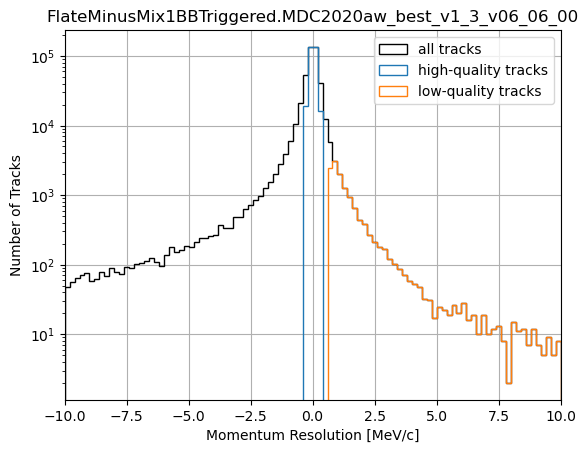

In [8]:
min_mom_res=-10
max_mom_res=10
n_mom_res_bins=100

training_dataset = datasets[0]
fig, ax = plot_mom_res(training_dataset, n_mom_res_bins, min_mom_res, max_mom_res)

Here we plot all the training features. Note that we have used ```density=True``` so each histogram is normalized to unit area

In [9]:
def plot_features(dataset):
    fig, axs = plt.subplots(3, 3, figsize=(16,9))
    fig.subplots_adjust(hspace=.5)

    x_mins=[0, 0, 0, 0, 0, 0, 0]
    x_maxs=[100, 1, 3, 1, 1, 5, 5]
    log_ys=[False, True, True, True, True, True, True]
    #log_ys=[False, False, False, False, False, False, False]
    units=['[count]', '[fraction]', '[ns]', '[fraction]', '', '[MeV/c]', '[1/fraction]']
    density=True
    fig.suptitle('.'.join(dataset.dataset.split('.')[2:4]))

    for i_var in range(0, n_input_vars):
        bins, counts, patches = axs.flatten()[i_var].hist(dataset.features[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', color='black', log=log_ys[i_var], label='all tracks', density=density)
        bins, counts, patches = axs.flatten()[i_var].hist(dataset.features[:,i_var][dataset.high_qual], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='high-quality tracks', density=density)
        bins, counts, patches = axs.flatten()[i_var].hist(dataset.features[:,i_var][dataset.low_qual], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='low-quality tracks', density=density)
        axs.flatten()[i_var].set_xlabel(input_var_names[i_var]+" "+units[i_var])
        axs.flatten()[i_var].margins(0)
        axs.flatten()[i_var].legend()

    return fig, ax

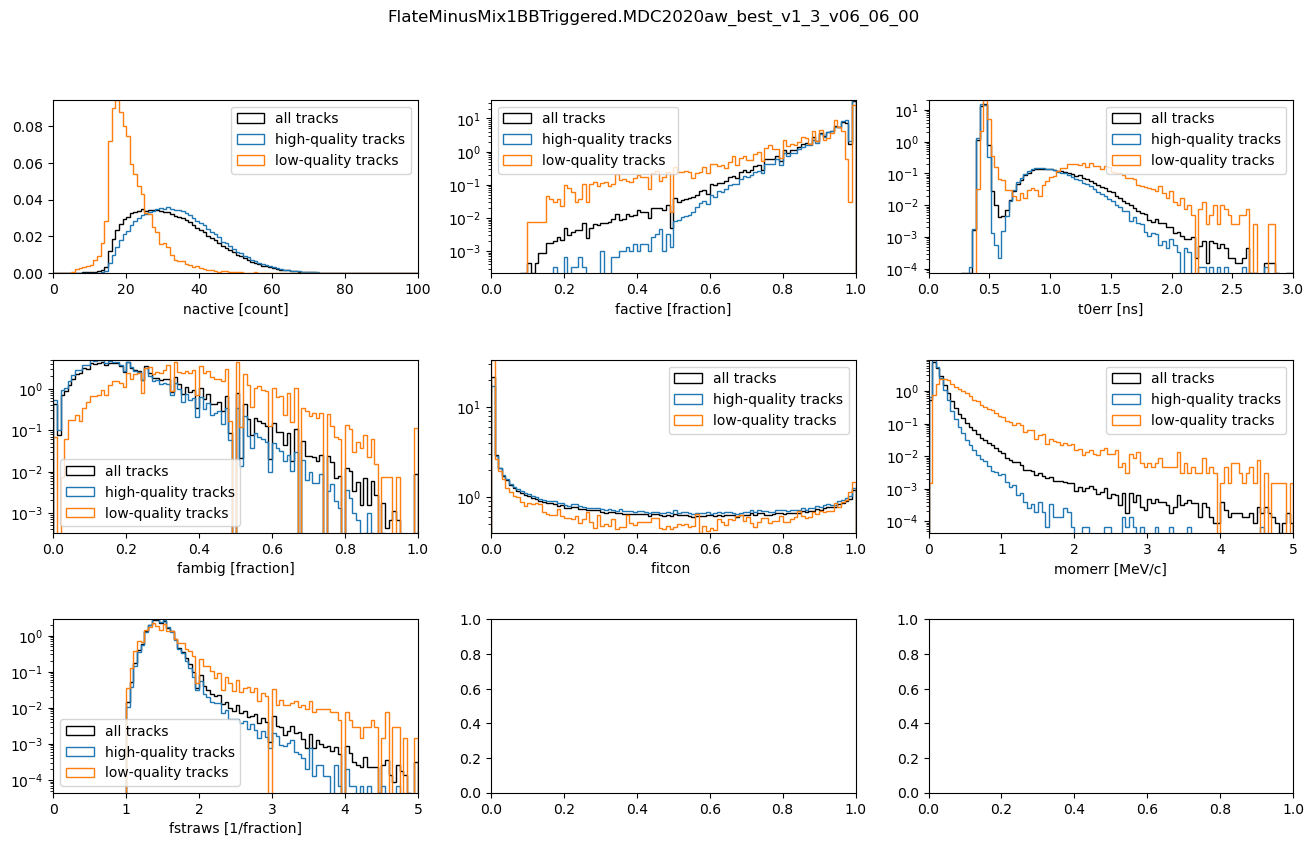

In [10]:
training_dataset = datasets[0]
fig, ax = plot_features(training_dataset)

Now we balance the inputs since we don't have that many low-quality tracks to train on

In [11]:
# In this cell x_ variables are features, and y_ are the classes
min_len = min(len(training_dataset.features[training_dataset.high_qual]), len(training_dataset.features[training_dataset.low_qual]))

x_high_qual_dataset = training_dataset.features[training_dataset.high_qual][:min_len]
x_low_qual_dataset = training_dataset.features[training_dataset.low_qual][:min_len]

x_balanced_input = np.concatenate((x_high_qual_dataset, x_low_qual_dataset))
# set 1 to be high quality, and 0 to be low quality
y_balanced_input = np.concatenate((np.ones(x_high_qual_dataset.shape[0]), np.zeros(x_low_qual_dataset.shape[0])))

# split the dataset into train and test samples
x_train, x_test, y_train, y_test = train_test_split(x_balanced_input, y_balanced_input, test_size=0.5, random_state=42)
print("N train = "+str(len(x_train)) + ", N test = "+str(len(x_test)))
print("Validation dataset will be "+validation_dataset.dataset)

N train = 13449, N test = 13449
Validation dataset will be nts.mu2e.CeEndpointMix1BBTriggered.MDC2020aw_best_v1_3_v06_06_00.root


# Define Models

Now we will define some models to train. In addition to the ANN, we will train a LinearDiscriminant to make sure there is not a simpler algorithm that
works

## Linear and Quadratic Discriminant

In [12]:

lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train) 

qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train) 

QuadraticDiscriminantAnalysis()

## Artificial Neural Network
 - N, N-1 neurons in the hidden layers
 - sigmoid activation functions
 - no dropout layers

In [23]:
keras.utils.set_random_seed(340)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3) # was 1e-3 (2e-2 is from TMVA)

N=n_input_vars
activation_function='sigmoid' # 'relu' # 'relu' # was 'sigmoid'
#N=64
ann = tf.keras.Sequential(name='sequential')
input_layer = tf.keras.layers.Input(shape=(n_input_vars,), batch_size=1, name='input')
ann.add(input_layer)
ann.add(tf.keras.layers.Dense(n_input_vars, activation=activation_function, name='dense'))#, input_shape=(n_input_vars,)))
#model_ce.add(Dropout(0.00005))
ann.add(tf.keras.layers.Dense(n_input_vars, activation=activation_function, name='dense_1')) # also 'relu', 'softmax'
#model_ce.add(Dropout(0.00005))
ann.add(tf.keras.layers.Dense(n_input_vars-1, activation=activation_function, name='dense_2'))
#model_ce.add(Dropout(0.00005))
ann.add(tf.keras.layers.Dense(1, activation=activation_function, name='dense_3'))
ann.compile(loss='binary_crossentropy',
                 metrics=['accuracy'],
                 optimizer=opt)
                 #run_eagerly=True)
ann.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = ann.fit(x_train, y_train,
                          epochs=500,
                    #steps_per_epoch=10,
                          verbose=0,
                          validation_data=(x_test, y_test),
                          callbacks=[early_stop])
print("Done!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (32, 7)                   56        
                                                                 
 dense_1 (Dense)             (32, 7)                   56        
                                                                 
 dense_2 (Dense)             (32, 6)                   48        
                                                                 
 dense_3 (Dense)             (32, 1)                   7         
                                                                 
Total params: 167 (668.00 Byte)
Trainable params: 167 (668.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Done!


## Compare Models
Now we will compare different models

In [14]:
models = [lda, qda, ann]
model_names = ["LDA", "QDA", "ANN"]

An LDA trkqual cut of 0.9134481111271061 has a low-quality track rejection of 99.0% with a high-quality track efficiency of 38.0%
An QDA trkqual cut of 0.9998970475650698 has a low-quality track rejection of 99.0% with a high-quality track efficiency of 31.4%
9920/9920 [==============================] - 7s 652us/step
An ANN trkqual cut of 0.945685 has a low-quality track rejection of 99.0% with a high-quality track efficiency of 48.9%


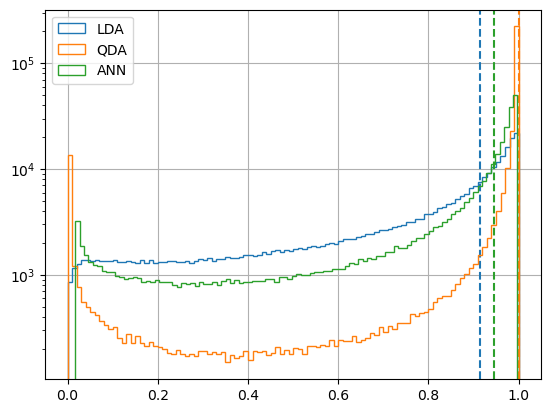

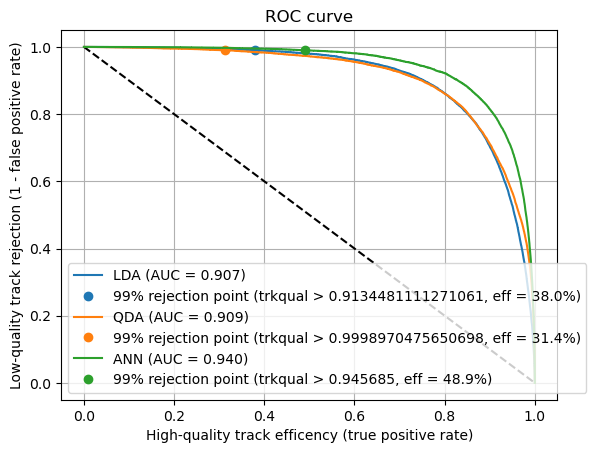

In [15]:


y_full_input_dataset = np.concatenate((np.ones(training_dataset.features[training_dataset.high_qual].shape[0]), np.zeros(training_dataset.features[training_dataset.low_qual].shape[0])))
x_full_input_dataset = np.concatenate((training_dataset.features[training_dataset.high_qual], training_dataset.features[training_dataset.low_qual]))

fig, axs = plt.subplots(1,1)
axs.set_yscale('log')

fig2, axs2 = plt.subplots(1,1)
axs2.plot([0, 1], [1, 0], 'k--') # plot the straight line

trkqual_cuts=[]
predictions = []
for model,name in zip(models, model_names):
    
    if (name != "ANN"):
        prediction = model.predict_proba(x_full_input_dataset)[:,1].ravel() # probability that it's a high-quality track
    else:
        prediction = model.predict(x_full_input_dataset)
    
    fpr, tpr, thresholds = roc_curve(y_full_input_dataset, prediction, pos_label=1)    
    auc_result = auc(fpr, tpr)

    cut_val_index=0
    for i_point in range(0, len(fpr)):
        if 1-fpr[i_point]<0.99:
            cut_val_index=i_point-1
            break
        
    trkqual_cut=thresholds[cut_val_index]#(round(thresholds[cut_val_index], 2))

    axs.hist(prediction, bins=100, label=name, histtype='step')
    axs.axvline(x=trkqual_cut, linestyle='--', color=axs.patches[-1].get_edgecolor())
    
    trkqual_cuts.append(trkqual_cut)
    bkg_rej = 1-fpr[cut_val_index]
    sig_eff = tpr[cut_val_index]
    print("An "+name+" trkqual cut of "+str(trkqual_cut)
          +" has a low-quality track rejection of "+str(round(bkg_rej*100,1))
          +"% with a high-quality track efficiency of "+str(round(sig_eff*100,1))+"%")


    axs2.plot(tpr, 1-fpr, label=name+' (AUC = {:.3f})'.format(auc_result))
    axs2.plot(tpr[cut_val_index], 1-fpr[cut_val_index], 'o', color=axs2.lines[-1].get_color(), label='99% rejection point (trkqual > '+str(trkqual_cut)+', eff = '+str(round(sig_eff*100,1))+'%)')

axs.legend()
axs.grid(True)

axs2.set_xlabel('High-quality track efficency (true positive rate)')
axs2.set_ylabel('Low-quality track rejection (1 - false positive rate)')
axs2.set_title('ROC curve')
axs2.legend(loc='best')
axs2.grid(True)
plt.show()

In [16]:
# Claculate all predictions in both training and validation datasets
for dataset in datasets:
    predictions = []
    for model,name,cut in zip(models, model_names, trkqual_cuts):
        if (name != "ANN"): #  need to predict again because ROC curve doesn't use tracks that are between high qual and low-qual
            prediction = model.predict_proba(dataset.features)[:,1].ravel() # probability that it's a high-quality track
            predictions.append(prediction)
        else:
            prediction = model.predict(dataset.features)[:,0]
            predictions.append(prediction)
    dataset.add_predictions(predictions)
        

  244/38067 [..............................] - ETA: 23s

2025-09-22 10:19:27.517067: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34107920 exceeds 10% of free system memory.


10697/10697 [==============================] - 7s 643us/step


LDA [0.79367723 0.81692838 0.99706713 ... 0.7112564  0.72244168 0.05245409] 0.9134481111271061
QDA [0.99941352 0.99994477 1.         ... 0.9282197  0.99592516 0.20783732] 0.9998970475650698
ANN [0.9358912  0.87946725 0.99520355 ... 0.48936978 0.9073244  0.12487207] 0.945685
LDA [0.95849539 0.23348956 0.98040981 ... 0.48572283 0.70697776 0.80020134] 0.9134481111271061
QDA [0.99987516 0.94262402 0.99999737 ... 0.96823687 0.95726468 0.9975842 ] 0.9998970475650698
ANN [0.99187964 0.6825721  0.9696292  ... 0.50737    0.87623936 0.97859484] 0.945685
LDA [0.73776046 0.62476294 0.65963906 ... 0.67513296 0.09416857 0.25476358] 0.9134481111271061
QDA [9.66078752e-01 3.56397320e-06 9.70164949e-01 ... 9.75046364e-01
 8.38425472e-02 6.87993250e-06] 0.9998970475650698
ANN [0.9819938  0.08244576 0.8816134  ... 0.94697607 0.09228203 0.04847946] 0.945685


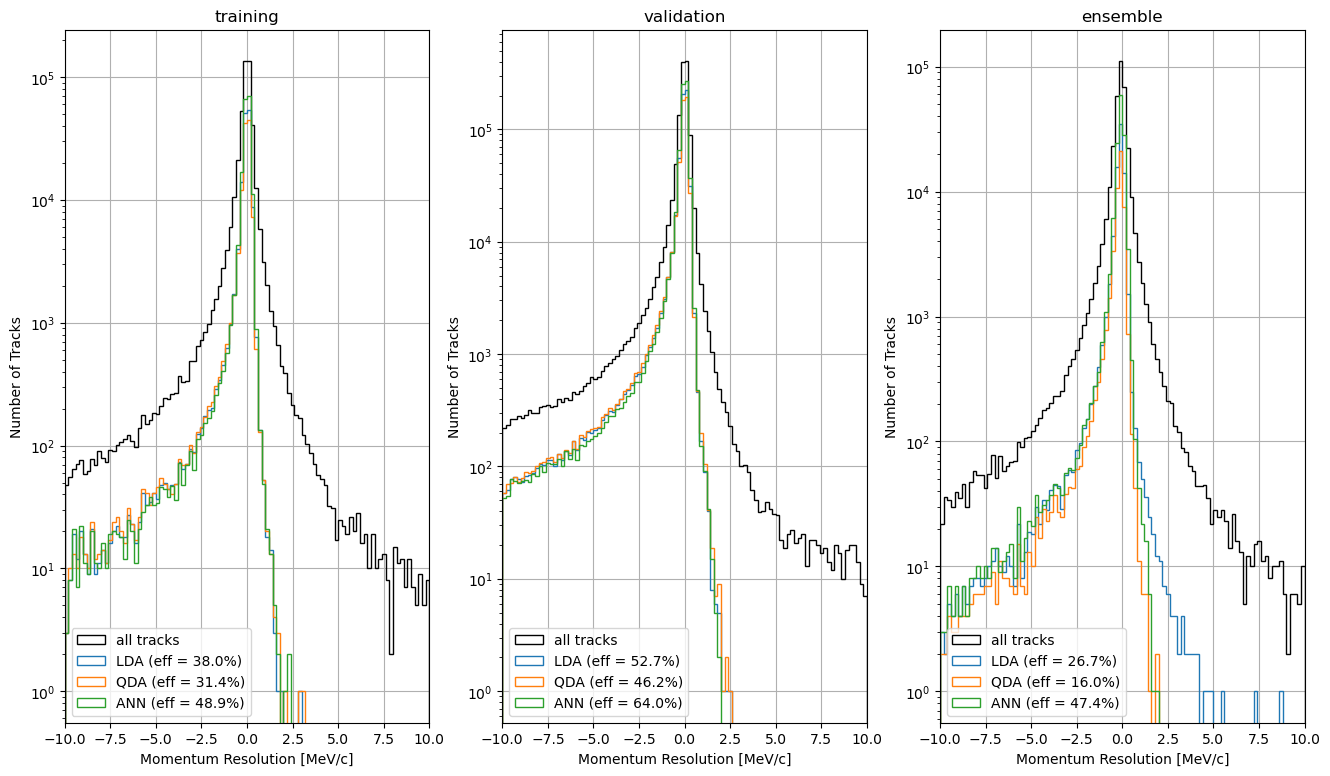

In [17]:
fig, axs = plt.subplots(1,3, figsize=(16,9))

for dataset,ax in zip(datasets, axs.ravel()):
    _, _, _, = ax.hist(dataset.mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', color='black', label='all tracks')
    for model,name,cut,prediction in zip(models, model_names, trkqual_cuts, dataset.predictions):
        print(name, prediction, cut)
        n_high_qual_all = len(dataset.mom_res[dataset.high_qual])
        n_high_qual_select = len(dataset.mom_res[(prediction>=cut) & (dataset.high_qual)])
        eff = n_high_qual_select / n_high_qual_all
        _, _, _, = ax.hist(dataset.mom_res[prediction>=cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', 
                            label=name + " (eff = " + str(round(eff*100,1)) + "%)")
    ax.legend()
    ax.margins(x=0)
    ax.grid(True)
    ax.set_title(dataset.id)
    ax.set_xlabel("Momentum Resolution [MeV/c]")
    ax.set_ylabel("Number of Tracks")

0.37999480247770495 7.750118162508368e-07
0.3135257293801461 7.080001708653638e-07
0.4893467240806471 8.220113199841617e-07
0.5273562877247182 2.802135531942973e-07
0.46232334236084643 2.794590208965442e-07
0.6396549533840807 2.591287542874632e-07
0.2672704001545558 9.458578674598206e-07
0.15972856142384506 6.482438128126156e-07
0.47399357627568883 1.2041829865194753e-06


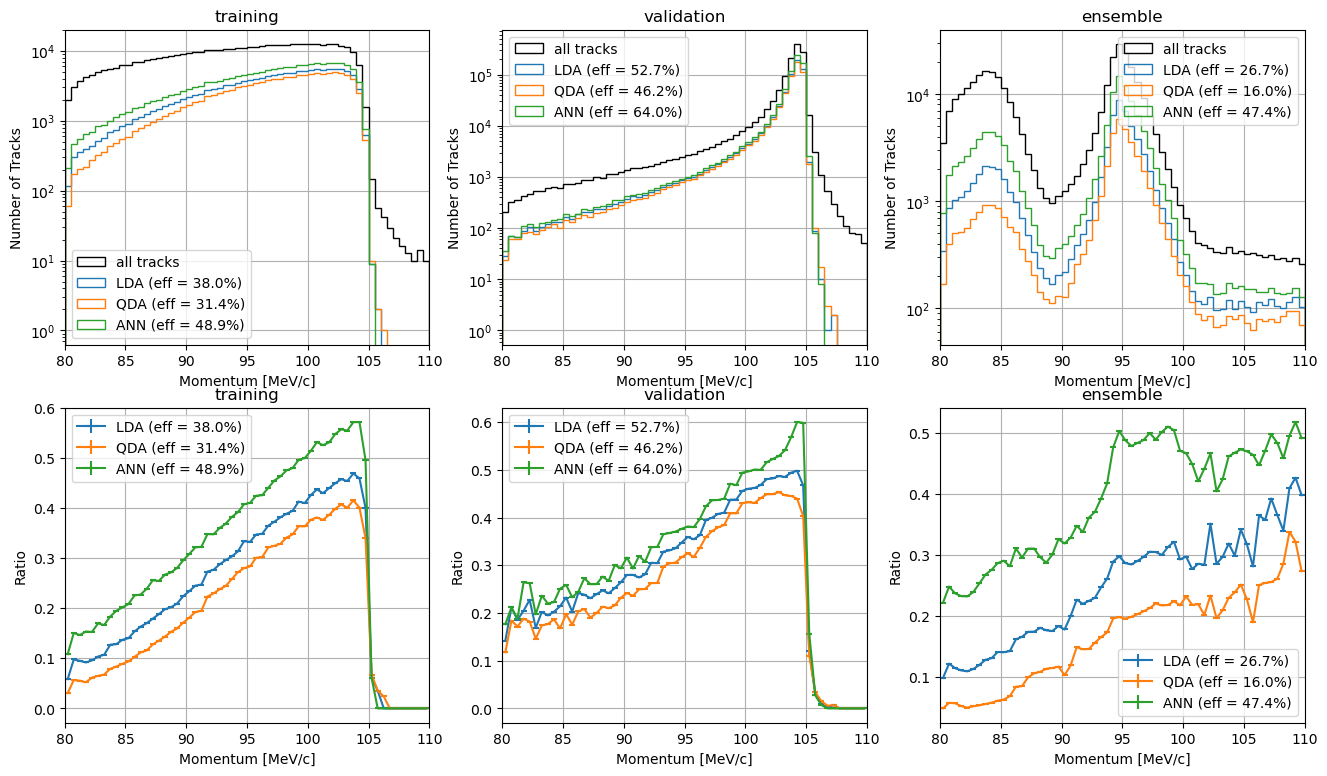

In [19]:
fig, axs = plt.subplots(2,3, figsize=(16,9))

n_reco_mom_bins=60
min_reco_mom=80
max_reco_mom=110

for i,dataset in enumerate(datasets):
    all_counts, _, _, = axs[0][i].hist(dataset.reco_mom, bins=n_reco_mom_bins, range=(min_reco_mom,max_reco_mom), log=True, histtype='step', color='black', label='all tracks')
    for model,name,cut,prediction in zip(models, model_names, trkqual_cuts, dataset.predictions):
        #print(name, prediction, cut)
        n_high_qual_all = len(dataset.mom_res[dataset.high_qual])
        n_high_qual_select = len(dataset.mom_res[(prediction>=cut) & (dataset.high_qual)])
        eff = n_high_qual_select / n_high_qual_all
        eff_err =  ((n_high_qual_select + 1)*(n_high_qual_select + 2)) / ((n_high_qual_all + 2)*(n_high_qual_all + 3)) - ( (n_high_qual_select + 1)**2 / (n_high_qual_all + 2)**2 )
        print(eff, eff_err)
        cut_counts, bins, _, = axs[0][i].hist(dataset.reco_mom[prediction>=cut], bins=n_reco_mom_bins, range=(min_reco_mom,max_reco_mom), log=True, histtype='step', 
                                            label=name + " (eff = " + str(round(eff*100,1)) + "%)")
        ratio = np.divide(cut_counts, [float(x) for x in all_counts], out=np.zeros_like(cut_counts, dtype=float), where=all_counts!=0)
        _ = axs[1][i].errorbar((bins[:-1] + bins[1:]) / 2, ratio, xerr=(bins[1]-bins[0])/2, yerr=eff_err,
                                            label=name + " (eff = " + str(round(eff*100,1)) + "%)")
    axs[0][i].legend()
    axs[0][i].margins(x=0)
    axs[0][i].grid(True)
    axs[0][i].set_title(dataset.id)
    axs[0][i].set_xlabel("Momentum [MeV/c]")
    axs[0][i].set_ylabel("Number of Tracks")

    axs[1][i].legend()
    axs[1][i].margins(x=0)
    axs[1][i].grid(True)
    axs[1][i].set_title(dataset.id)
    axs[1][i].set_xlabel("Momentum [MeV/c]")
    axs[1][i].set_ylabel("Ratio")

Now we save the model

In [24]:
tspecs = [tf.TensorSpec(i.shape, dtype=i.dtype, name=i.name) for i in ann.inputs]
onnx_model, _ = tf2onnx.convert.from_keras(ann, input_signature=tspecs)
onnx.save(onnx_model, 'model/TrkQual_ANN1_v2.onnx')

2025-09-22 10:23:35.899349: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-09-22 10:23:35.899436: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-22 10:23:35.922759: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-09-22 10:23:35.922817: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


### Some Validation Plots

### plot_loss

The ```plot_loss``` function will be used later after the model is trained

Here is the loss as a function of epoch for the training and validation datasets

In [21]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss (training)')
  plt.plot(history.history['val_loss'], label='loss (testing)')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

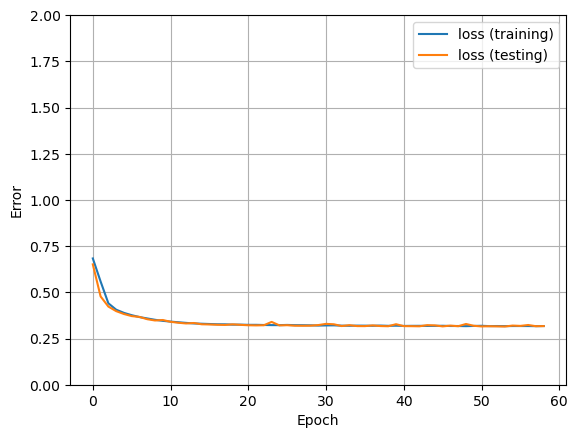

In [22]:
plot_loss(history)

Text(7, 0.5, 'low-quality tracks')

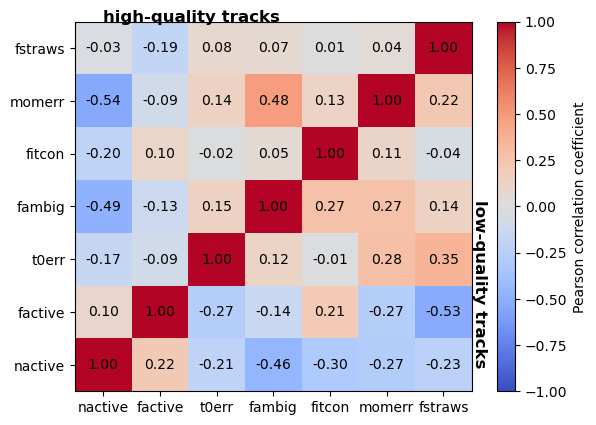

In [17]:
qualities = [ high_qual, low_qual ]
qual_labels = ["high", "low"]

xs = np.linspace(0,n_input_vars-1,n_input_vars)
ys = xs
x_corrs=[]
y_corrs=[]
corrs=[]#np.ndarray((n_input_vars,n_input_vars))
for qual_label,quality in zip(qual_labels,qualities):
    for i_x,x in enumerate(xs):
        x_i = input_dataset[:,i_x][quality]
        mean_x = np.mean(x_i)
        for i_y,y in enumerate(ys):
            if qual_label=="high":
                if (y<x):
                    continue
            elif qual_label=="low":
                if (y>=x):
                    continue
            y_i = input_dataset[:,i_y][quality]
            mean_y = np.mean(y_i)
            corr =  ( np.sum((x_i-mean_x)*(y_i - mean_y)) ) / ((np.sqrt(np.sum((x_i-mean_x)**2)))*(np.sqrt(np.sum((y_i-mean_y)**2))))
            x_corrs.append(x+0.5)
            y_corrs.append(y+0.5)
            corrs.append(corr)

#print(x_corrs)
#print(corrs)
H, xedges, yedges = np.histogram2d(x_corrs, y_corrs, bins=np.linspace(0,n_input_vars,n_input_vars+1), weights=corrs)
X, Y = np.meshgrid(xedges, yedges)
heatmap = plt.pcolormesh(Y, X, H, cmap='coolwarm')
cbar = plt.colorbar(heatmap)
plt.clim(-1,1)
_ = plt.xticks(xs+0.5, input_var_names)
_ = plt.yticks(ys+0.5, input_var_names)
cbar.ax.set_ylabel("Pearson correlation coefficient")
#print(yedges[:-1])
for x,y,corr in zip(x_corrs,y_corrs,corrs):
    if (abs(corr)>0.0):
        plt.text(x, y, '%.2f' % corr,
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.text(0.5, 7, "high-quality tracks", fontsize='large', fontweight='bold')#, horizontalalignment='center')#, rotation=45)
plt.text(7, 0.5, "low-quality tracks", fontsize='large', fontweight='bold', rotation=-90)#, verticalalignment='center', rotation=-90)

In [19]:
# Write out all histograms and plots to a ROOT file for future reference
outfile = uproot.recreate(output_modelname+"_plots.root")

# Momentum resolution plots
mom_res_hist_all = np.histogram(mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["all_mom_res"] = mom_res_hist_all
mom_res_hist_high_qual = np.histogram(mom_res[high_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["high_qual_mom"] = mom_res_hist_high_qual
mom_res_hist_low_qual = np.histogram(mom_res[low_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["low_qual_mom_res"] = mom_res_hist_low_qual
mom_res_hist_pass = np.histogram(mom_res[(trkqual>=trkqual_cut)], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["pass_mom_res"] = mom_res_hist_pass
mom_res_hist_fail = np.histogram(mom_res[(trkqual<trkqual_cut)], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["fail_mom_res"] = mom_res_hist_fail

# datasets (input, train, text, and valid)
datasets=[input_dataset, input_dataset, input_dataset, x_train, x_test, x_valid, input_dataset, input_dataset]
prefixes = ["all_", "high_qual_", "low_qual_", "train_", "test_", "valid_", "pass_", "fail_"]
cuts = [(), (high_qual), (low_qual), (), (), (), (trkqual>=trkqual_cut), (trkqual<trkqual_cut)]
# Feature histograms
for dataset,prefix,cut in zip(datasets, prefixes, cuts):
    for i_var in range(0, n_input_vars):
        feature_all = np.histogram(dataset[:,i_var][cut], bins=100, range=(x_mins[i_var],x_maxs[i_var]))
        outfile[prefix+"feature"+str(i_var)+"_"+input_var_names[i_var]] = feature_all
        feature_norm_all = np.histogram(dataset[:,i_var][cut], bins=100, range=(x_mins[i_var],x_maxs[i_var]), density=True)
        outfile[prefix+"feature"+str(i_var)+"_"+input_var_names[i_var]+"_norm"] = feature_norm_all

import pandas as pd
df = pd.DataFrame({"tpr" : tpr_keras, "fpr" : fpr_keras, "thresh" : thresholds_keras})
outfile["roc_curve"] = df

outfile["corr_matrix"] = H,xedges,yedges

In [19]:
import keras
print(keras.__version__)

2.15.0
